<a href="https://colab.research.google.com/github/edakavlakoglu/mids/blob/master/eda_kavlakoglu_project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Poisonous Mushrooms

**Solution**

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

## Grading
---
- Make sure to answer every part in every question.
 - There are 6 equally weighted questions.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

In [ ]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [ ]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [ ]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [ ]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Question 1:PCA and fraction of total variance
---

1. Do a principal components analysis on the data.
1. Print what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].
1. Show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
1. You only need to call PCA.fit once.

Notes:
* The pandas DataFrame [cumsum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html) function may be helpful.
* You can use `PCA` to produce a PCA analysis.

Fraction of the total variance explained by the first principal component: 16.40%
Fraction of the total variance explained by the first 2 principal components: 29.73%
Fraction of the total variance explained by the first 3 principal components: 39.90%
Fraction of the total variance explained by the first 4 principal components: 46.96%
Fraction of the total variance explained by the first 5 principal components: 50.83%
Fraction of the total variance explained by the first 10 principal components: 65.22%
Fraction of the total variance explained by the first 20 principal components: 80.89%
Fraction of the total variance explained by the first 30 principal components: 89.85%
Fraction of the total variance explained by the first 40 principal components: 95.09%
Fraction of the total variance explained by the first 50 principal components: 98.21%


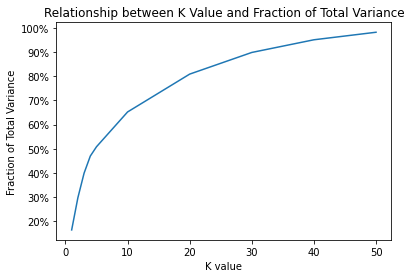

In [ ]:
#CREDIT TO SOURCES: 
#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff

def P1():
    #define k values for testing
    k_values = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]

    #empty list 
    fract_total_var = []

    for k in k_values:
      pca = PCA(n_components=k)
      principalComponents = pca.fit_transform(train_data)
      explained_variance_ratios = pca.explained_variance_ratio_.cumsum()
      explained_var = explained_variance_ratios[k-1]
      fract_total_var.append(explained_var)
      
      if k == 1:
        print("Fraction of the total variance explained by the first principal component: {:.2%}".format(explained_var))
      else:
        print("Fraction of the total variance explained by the first", k, "principal components: {:.2%}".format(explained_var))


    #plot line graph 
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(k_values, fract_total_var)
    ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    ax.set_title("Relationship between K Value and Fraction of Total Variance")
    ax.xaxis.set_label_text("K value")
    ax.yaxis.set_label_text("Fraction of Total Variance")
P1()

### Question 2: PCA for visualization

PCA can be very useful for visualizing data. 
1. Project the training data down to 2 dimensions and show as a square scatterplot.
  - Show poisonous examples (labeled 1) in red and non-poisonous examples in green (labeled 0)
  - Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.
* Be sure to add a title, axis labels and a legend to your graph.

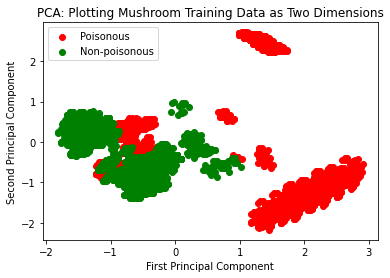

In [ ]:
#CREDIT TO SOURCES: 
#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

def Q2():   
  #project training data to 2 dimensions
   pca = PCA(n_components=2)
   principalComponents = pca.fit_transform(train_data)
   df = pd.DataFrame(principalComponents, columns = ['principal_comp_1', 'principal_comp_2'])

   #plot scatterplot
   fig, ax = plt.subplots(figsize=(6,4))
   ax.scatter(df['principal_comp_1'][train_labels==1],df['principal_comp_2'][train_labels==1], color='red', label = 'Poisonous')
   ax.scatter(df['principal_comp_1'][train_labels==0],df['principal_comp_2'][train_labels==0], color = 'green', label = 'Non-poisonous')
   ax.set_title("PCA: Plotting Mushroom Training Data as Two Dimensions")
   ax.xaxis.set_label_text("First Principal Component")
   ax.yaxis.set_label_text("Second Principal Component")
   ax.legend()

Q2()

### Question 3: Visualizing GMMs
---

1. Fit a k-means cluster model with 6 clusters over the 2d projected data. 
  - As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  
  - For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

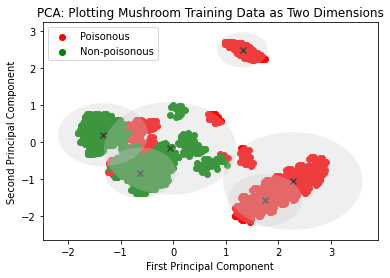

In [ ]:
#CREDIT TO SOURCES: 
#https://datascience.stackexchange.com/questions/32753/find-cluster-diameter-and-associated-cluster-points-with-kmeans-clustering-scik
#https://nicholasvadivelu.com/2021/05/10/fast-k-means/
#https://www.askpython.com/python/examples/plot-k-means-clusters-python 
#https://medium.com/analytics-vidhya/implementation-of-principal-component-analysis-pca-in-k-means-clustering-b4bc0aa79cb6

def Q3():   
  #project training data to 2 dimensions
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(train_data)
  df = pd.DataFrame(principalComponents, columns = ['principal_comp_1', 'principal_comp_2'])

  #initiate kmeans cluster
  cluster_num = 6
  estimator = KMeans(n_clusters=cluster_num)
  kmeans = estimator.fit(principalComponents)
  kmeans_labels = kmeans.predict(principalComponents)

  #find cluster centers
  centroids = kmeans.cluster_centers_

  #plot scatterplot
  fig, ax = plt.subplots(figsize=(6,4))
  ax.scatter(df['principal_comp_1'][train_labels==1],df['principal_comp_2'][train_labels==1], color='red', label = 'Poisonous')
  ax.scatter(df['principal_comp_1'][train_labels==0],df['principal_comp_2'][train_labels==0], color = 'green', label = 'Non-poisonous')
  plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='k')
  ax.set_title("PCA: Plotting Mushroom Training Data as Two Dimensions")
  ax.xaxis.set_label_text("First Principal Component")
  ax.yaxis.set_label_text("Second Principal Component")
  ax.legend()

  for l, c in enumerate(centroids):
    dist = np.max([np.linalg.norm((np.array(x) - np.array(c))) for x in principalComponents[l == kmeans_labels]])
    ax.add_patch(plt.Circle(c, dist, fc='#CCCCCC', alpha=0.3))
Q3()

### Question 4: Understanding GMMs with Density Plots
---

1. Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. 
  - Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  
  - Show a 4x4 grid of square-shaped plots of the estimated density contours. 
    - Each row showing a different number of mixture components. 
    - Each column showing a different convariance matrix type.  
1. Be sure to add a title for each plot in the grid to indicate what parameters were used.
1. How are the covariance types 'tied' and 'full' different? How do you see it in the plots?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

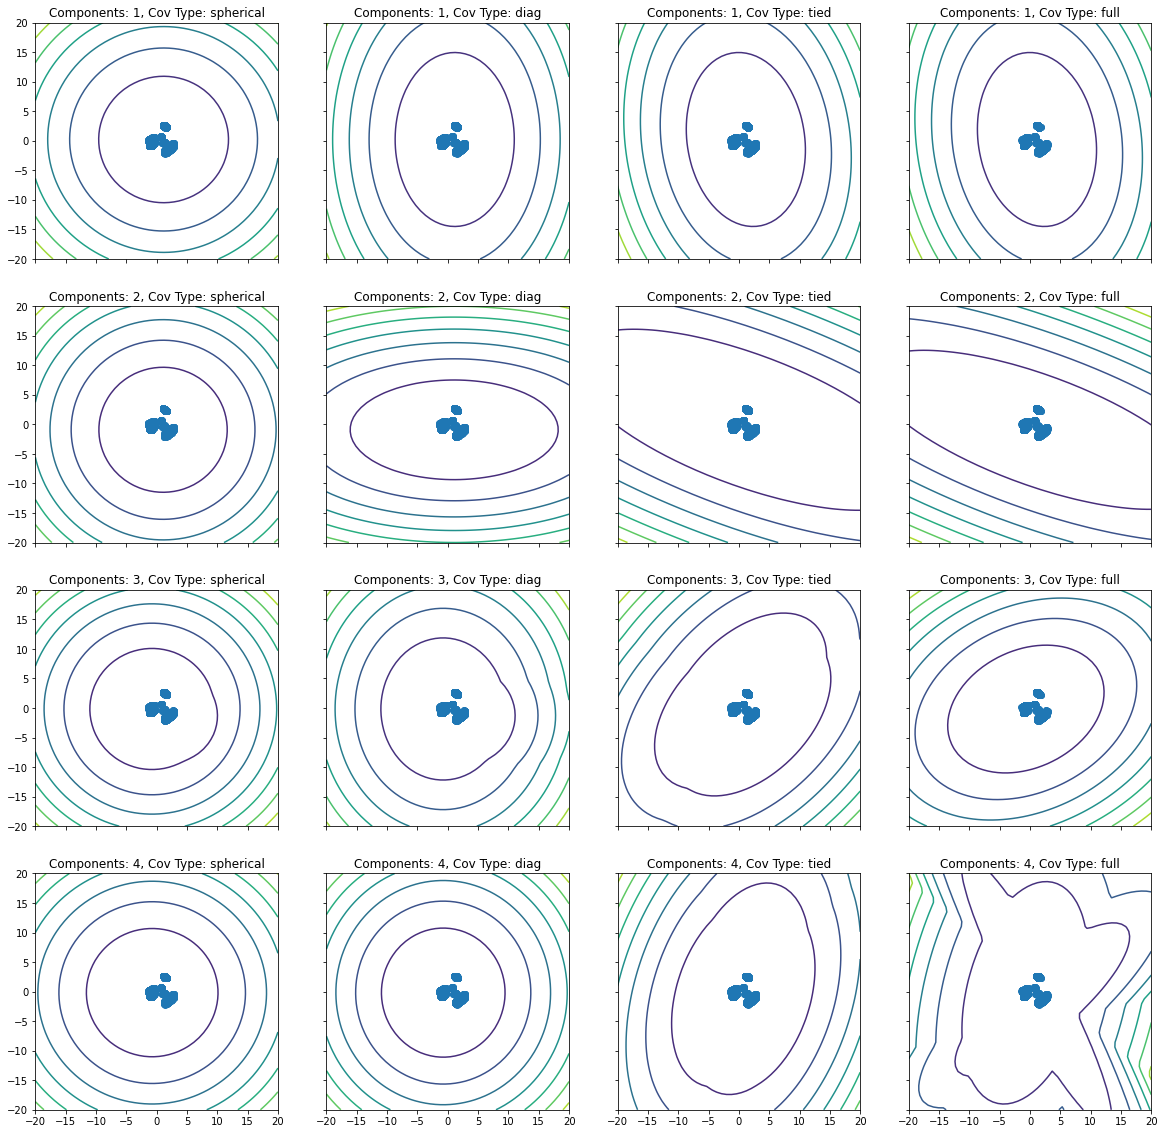

In [ ]:
#CREDIT TO SOURCES: 
#https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html 
#https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html
#https://pythonmachinelearning.pro/clustering-with-gaussian-mixture-models/

def Q4():

    #project training data to 2 dimensions
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(train_data)[train_labels == 1]

    mix_components = [1, 2, 3, 4]
    cov_type = ['spherical', 'diag', 'tied', 'full']

    #set up 16 subplots 
    fig, ax = plt.subplots(4, 4, sharex='all', sharey='all', figsize=(20, 20))
    
    #loop through various mixture components and covariance types above
    for m in range(len(mix_components)):
      for c in range(len(cov_type)):

        #fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data.
        gmm = GaussianMixture(n_components=mix_components[m], covariance_type=cov_type[c], random_state=12345).fit(principalComponents)
        labels = gmm.predict(principalComponents)
    
        #calculate estimated density contours
        X, Y = np.meshgrid(np.linspace(-20, 20), np.linspace(-20, 20))
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -gmm.score_samples(XX)
        Z = Z.reshape(X.shape)
        CS = ax[m][c].contour(X, Y, Z)

        #plot estimated density contours
        ax[m][c].scatter(principalComponents[:, 0], principalComponents[:, 1])
        ax[m][c].set_title("Components: " + str(mix_components[m]) + ", Cov Type: " + str(cov_type[c]))

Q4()

Answer: The “tied” covariance type assumes that  the components have the same variance while the “full” covariance type assumes that each individual component has its own variance. This is best illustrated in the plots with four components above, where the “tied” version has more of an ellipse shape and the "full" version has more variation in its density plot. 

### Question 5: Using Unsupervised models for classification...?
---

1. Fit two Gaussian mixture models:
  - On your 2d projected training data. 
    - Form a subset of all the poisonous examples and fit one GMM (gmm_poison).
    - Form a subset of all the non-poisonous examples and fit another GMM (gmm_nonpoison).
  - Use 4 mixture components and full convariance for each model.  
1. Use the above trained GMMs to classify examples in your test set:
   - For each example in the test set
     - Measure how likely it is to have been "generated" by gmm_poison and gmm_nonpoison (using score_samples).
     - Predict the more likely label.
  - You can use score_samples.
  - You can do this without a for loop which will be more efficient.
1. What is the accuracy of the predictions on the test data? (we expect it to be about 0.95)

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [ ]:
#CREDIT TO SOURCES: 
#https://www.oneoffcoder.com/2019/10/02/gaussian-mixture-models/

def Q5():  
  
  #project training and test data to 2 dimensions
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(train_data)
  poisonous = principalComponents[train_labels == 1]
  non_poisonous = principalComponents[train_labels == 0]
  test = pca.transform(test_data)

  #fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data.
  gmm_poison = GaussianMixture(n_components=4, covariance_type='full', random_state=12345).fit(poisonous)
  gmm_poison_scores = np.exp(gmm_poison.score_samples(test))

  #fit Gaussian mixture models for the negative (non-poisonous) examples in your 2d projected data.
  gmm_nonpoison = GaussianMixture(n_components= 4, covariance_type='full', random_state=12345).fit(non_poisonous)
  gmm_nonpoison_scores = np.exp(gmm_nonpoison.score_samples(test))

  #compare scores to get predicted label
  predicted_labels = gmm_poison_scores > gmm_nonpoison_scores

  #calculate accuracy 
  corr_predictions_cnt = sum(predicted_labels == test_labels)
  predicted_labels_cnt = len(predicted_labels)
  accuracy = corr_predictions_cnt/predicted_labels_cnt
  print("The accuracy of the predictions on the test data is: {:.2%}".format(accuracy))

Q5()

The accuracy of the predictions on the test data is: 95.02%


### Question 6: Understanding the GMM parameters
---

1. Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.
1. Print the best configuration and accuracy.
1. Plot a scatter plot of accuracy vs #params.
1. Bonus: Provide a better visualization by showing all four: accuracy, number of parameters, the covariance type and the number of PCA dimensions.



Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* [This spreadsheet](https://docs.google.com/spreadsheets/d/1LTEOU7q_Tgs4bX_3o2ePjDQrTRToZoc1J5XLlaRbmI0/edit?usp=sharing) should help (accessible from your google @berkeley.edu account)

* Spherical - Each GMM component has a mean per dimension, and one variance. 
* Diag - Each GMM component has a mean per dimension and a variance for each dimension.
* full - Each GMM component has a mean per dimension and a "full" covariance matrix. Only the covariance matrix is symmetric, so its $[i,j]$ entry would equal to its $[j,i]$ entry.
* tied - Finally, tied has all components share a single covariance matrix. So each GMM component has a mean per dimension but they all share the same 'full' covariance matrix.

Number of parameters: 44.0
Best accuracy: 96.98%
Best PCA value: 4
Best GMM component: 3
Best Covariance Matrix Type: tied


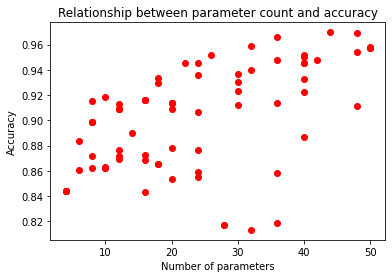

In [ ]:
#CREDIT TO SOURCES: 
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

from matplotlib.lines import Line2D

def calculate_n_cov(c, k, gmm):
          #calculate n_cov

          # full --> n_pca (n_pca + 1)/ 2 * n_gmm
          if c == 'full':
            n_cov = (k*(k+1)/2)*gmm
            return n_cov
          
          # diagonal --> n_pca * n_gmm
          if c == 'diag':
            n_cov = k * gmm
            return n_cov
            
          # spherical --> n_gmm
          if c == 'spherical':
            n_cov = gmm
            return n_cov
          
          # tied -> n_pca (n_pca + 1)/ 2
          if c == 'tied':
            n_cov = (k*(k+1)/2)
            return n_cov
          
def Q6():
    
    k_values = [1, 2, 3, 4, 5]
    mix_components = [1, 2, 3, 4, 5]
    cov_type = ['spherical', 'diag', 'tied', 'full']

    accuracies = []
    pca_values = []
    gmm_values = []
    cov_values = []
    parameter_values = []

    for k in k_values:
      for m in range(len(mix_components)):
        for c in range(len(cov_type)):

          #PCA 
          pca = PCA(n_components=k)
          principalComponents = pca.fit_transform(train_data)
          test = pca.transform(test_data)

          #fit Gaussian mixture models for the positive (poisonous) examples in your projected data.
          gmm_poison = GaussianMixture(n_components=mix_components[m], covariance_type= cov_type[c], random_state=12345).fit(principalComponents[train_labels == 1])
          gmm_poison_scores = np.exp(gmm_poison.score_samples(test))

          #fit Gaussian mixture models for the negative (non-poisonous) examples in your projected data.
          gmm_nonpoison = GaussianMixture(n_components= mix_components[m], covariance_type=cov_type[c], random_state=12345).fit(principalComponents[train_labels == 0])
          gmm_nonpoison_scores = np.exp(gmm_nonpoison.score_samples(test))

          #compare scores to get predicted label
          predicted_labels = gmm_poison_scores > gmm_nonpoison_scores

          #calculate accuracy 
          corr_predictions_cnt = sum(predicted_labels == test_labels)
          predicted_labels_cnt = len(predicted_labels)
          accuracy = corr_predictions_cnt/predicted_labels_cnt
        
          #calculate number of parameters // parameters = (n_mean + n_cov) * n_classes
          n_mean = k * mix_components[m]
          n_cov = calculate_n_cov(cov_type[c], k, mix_components[m])
          parameters = (n_mean + n_cov) * 2
       
          #save various components as lists 
          if parameters < 51:
            accuracies.append(accuracy)
            pca_values.append(k)
            gmm_values.append(mix_components[m])
            cov_values.append(cov_type[c])
            parameter_values.append(parameters)
    
    #save lists as array
    accuracies_arr = np.array(accuracies)
    pca_arr = np.array(pca_values) 
    gmm_arr = np.array(gmm_values)
    cov_arr = np.array(cov_values) 
    par_arr = np.array(parameter_values)

    #identify best index 
    max = np.where(accuracies_arr == accuracies_arr.max())
    max_index = max[0][0]

    #print the best configuration and accuracy
    print("Number of parameters:", par_arr[max_index])
    print("Best accuracy: {:.2%}".format(accuracies_arr[max_index]))
    print("Best PCA value:", pca_arr[max_index])
    print("Best GMM component:", gmm_arr[max_index])
    print("Best Covariance Matrix Type:", cov_arr[max_index])

    #plot scatterplot
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(par_arr, accuracies_arr, color='red')
    ax.set_title("Relationship between parameter count and accuracy")
    ax.xaxis.set_label_text("Number of parameters")
    ax.yaxis.set_label_text("Accuracy")

Q6()